## 导入库

In [1]:
import meshio
import numpy as np
import matplotlib.pyplot as plt
from math import *
%matplotlib inline

# 读取网格信息

In [2]:
mesh = meshio.read("waveguide_circle.msh", file_format = ("gmsh"))

# 节点坐标提取
nodes = mesh.points
Nn = nodes.shape[0]
x = nodes[:, 0]; y = nodes[:, 1]

# 物理组件编号提取
phy_line = mesh.cell_data_dict["gmsh:physical"]["line"]
phy_triangle = mesh.cell_data_dict["gmsh:physical"]["triangle"]

# 单元编码提取
ele_line = mesh.cells_dict["line"]
ele_triangle = mesh.cells_dict["triangle"]

# ele_filter 为单元筛选函数
def ele_filter(ele_data, phy_data, num_phy):
    num = np.where(phy_data == num_phy)
    count = len(num[0])
    elements = ele_data[num[0], :].T
    return (count, elements)

# 刚度矩阵计算

**根据单元泛函极值原理计算单元刚度矩阵方程**

$$
\begin{aligned}
    \frac{\partial F^e}{\partial \boldsymbol{\varphi}^e}&=\boldsymbol{K}^e\boldsymbol{\varphi}^e-\boldsymbol{b}^e=\boldsymbol{0}\\
    K_{ij}^e&=\iint_{\Omega^e}\left(\alpha_x\frac{\partial N_i^e}{\partial x}\frac{\partial N_j^e}{\partial x}+\alpha_y\frac{\partial N_i^e}{\partial y}\frac{\partial N_j^e}{\partial y}+\beta N_i^eN_j^e\right)\mathrm{d}x\mathrm{d}y\\
    &\approx\frac{1}{4\Delta^e}(\alpha_x^eb_i^eb_j^e+\alpha_y^ec_i^ec_j^e)+\frac{\Delta^e}{12}\beta^e(1+\delta_{ij})\\
    b_i^e&=\iint_{\Omega^e}fN_i^e\mathrm{d}x\mathrm{d}y\approx\frac{\Delta^e}{3}f^e
\end{aligned}
$$

**单元刚度矩阵方程组合为总刚度矩阵方程**

$$
\begin{aligned}
    \sum_{e=1}^M\frac{\partial F^e}{\partial \varphi^e}&=\sum_{e=1}^M\left(\boldsymbol{K}^e\boldsymbol{\varphi}^e-\boldsymbol{b}^e\right)\\
    &=\boldsymbol{K}\boldsymbol{\varphi}-\boldsymbol{b}=\boldsymbol{0}
\end{aligned}
$$

In [3]:
# stiffness_matrix  函数用于刚度矩阵方程的计算
def stiffness_matrix(Ne, n, K, B, alphax, alphay, beta, f):
    Ke = np.zeros((3, 3), dtype = complex)
    Be = np.zeros((3), dtype = complex)
    be = np.zeros((3), dtype = float)
    ce = np.zeros((3), dtype = float)
    
    for e in range(0, Ne):
        be[0] = y[n[1, e]]-y[n[2, e]]
        be[1] = y[n[2, e]]-y[n[0, e]]
        be[2] = y[n[0, e]]-y[n[1, e]]
        ce[0] = x[n[2, e]]-x[n[1, e]]
        ce[1] = x[n[0, e]]-x[n[2, e]]
        ce[2] = x[n[1, e]]-x[n[0, e]]
        # 三角单元面积
        Deltae = abs((be[0]*ce[1]-be[1]*ce[0]))/2.
        
        # 单元刚度矩阵计算
        for i in range(0, 3):
            for j in range(0, 3):
                if (i == j):
                    delta_ij = 1
                else:
                    delta_ij = 0
                Ke[i][j] = (alphax*be[i]*be[j]+alphay*ce[i]*ce[j])/(4.*Deltae)\
                        +Deltae*beta*(1+delta_ij)/12.
            Be[i] = Deltae*f/3.
        # 单元刚度矩阵组合至总刚度矩阵
        for i in range(0, 3):
            for j in range(0, 3):
                K[n[i][e]][n[j][e]] = K[n[i][e]][n[j][e]]+Ke[i][j]
            B[n[i][e]] = B[n[i][e]]+Be[i]
    return (K, B)

In [4]:
# 刚度矩阵初始化
K = np.zeros((Nn, Nn), dtype = complex)
b = np.zeros((Nn), dtype = complex)

lambda0 = 4
k0 = 2*pi/lambda0

In [5]:
# 空气处刚度矩阵方程计算
(Ne, n) = ele_filter(ele_triangle, phy_triangle, 14)
epsilon0 = 1; mur0 = 1; f = 0
alphax = 1/epsilon0; alphay = 1/epsilon0; beta = -k0**2*mur0
(K, b) = stiffness_matrix(Ne, n, K, b, alphax, alphay, beta, f)

In [6]:
# 介质处刚度矩阵方程计算
(Ne, n) = ele_filter(ele_triangle, phy_triangle, 10)
epsilon1 = 4+1000*1j; mur0 = 1; f = 0
alphax = 1/epsilon1; alphay = 1/epsilon1; beta = -k0**2*mur0
(K, b) = stiffness_matrix(Ne, n, K, b, alphax, alphay, beta, f)

# Robin 边界条件处理

**对边界单元求泛函极值，得到附加的单元刚度矩阵方程**

$$
\begin{aligned}
    \frac{\partial F_b^s}{\partial \boldsymbol{\varphi}^s}&=\boldsymbol{K}^s\boldsymbol{\varphi}^s-\boldsymbol{b}^s=\boldsymbol{0}\\
    K_{ij}^s&=\int_0^1\gamma N_i^sN_j^sl^s\mathrm{d}\zeta\approx\gamma^s\frac{l^s}{6}(1+\delta_{ij})\\
    b_i^s&=\int_0^1qN_i^sl^s\mathrm{d}\zeta\approx q^s\frac{l^s}{2}
\end{aligned}
$$

**单元刚度矩阵组合并附加至总刚度矩阵方程**

$$
\begin{aligned}
    \frac{\partial F}{\partial\boldsymbol{\varphi}}&=\sum_{e=1}^{M}\frac{\partial F}{\partial \varphi^e}+\sum_{s=1}^{M_s}\frac{\partial F_b^s}{\partial \varphi^s}\\
    &=\sum_{e=1}^M\left(\boldsymbol{K}^e\boldsymbol{\varphi}^e-\boldsymbol{b}^e\right)+\sum_{s=1}^{M_s}\left(\boldsymbol{K}^s\boldsymbol{\varphi}^s-\boldsymbol{b}^s\right)=\boldsymbol{0}
\end{aligned}
$$

In [7]:
# Robin_boundary 函数用于处理 Robin 边界条件 
def Robin_boundary(Ns, ns, K, B, gamma, q):
    Ks = np.zeros((2, 2), dtype = complex)

    for s in range(0, Ns):
        i = ns[0][s]
        j = ns[1][s]
        # 线段单元长度
        ls = sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)

        # 单元刚度矩阵元素
        Ks[0][0] = gamma*ls/3
        Ks[0][1] = gamma*ls/6
        Ks[1][0] = Ks[0][1]
        Ks[1][1] = Ks[0][0]
        
        # 单元刚度矩阵组合至总刚度矩阵
        for i in range(0, 2):
            for j in range(0, 2):
                K[ns[i][s]][ns[j][s]] = K[ns[i][s]][ns[j][s]]+Ks[i][j]
            B[ns[i][s]] = B[ns[i][s]]+q*ls/2

    return (K, B)

In [8]:
# 波导壁边界条件处理
(Ns, ns) = ele_filter(ele_line, phy_line, 6)
gamma = 0; q = 0
(K, b) = Robin_boundary(Ns, ns, K, b, gamma, q)

In [9]:
# 入射口处边界条件
(Ns, ns) = ele_filter(ele_line, phy_line, 7)
epsilon0 = 1; H0 = 2
alphax = 1/epsilon0; gamma = 1j*alphax*k0; q = 2*1j*alphax*k0*H0
(K, b) = Robin_boundary(Ns, ns, K, b, gamma, q)

In [10]:
# 出射口处边界条件
(Ns, ns) = ele_filter(ele_line, phy_line, 8)
epsilon0 = 1
alphax = 1/epsilon0; gamma = alphax*1j*k0; q = 0
(K, b) = Robin_boundary(Ns, ns, K, b, gamma, q)

# 求解刚度矩阵方程

In [11]:
Hz = np.linalg.solve(K, b)
Hz = np.abs(Hz)

# 后处理

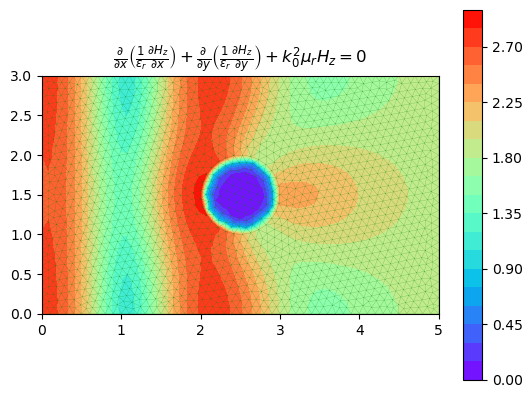

In [12]:
plt.tricontourf(x, y, Hz, levels = 20, cmap = 'rainbow')
plt.triplot(x, y, 'g-', linewidth=0.1)
plt.title(r'$\frac{\partial}{\partial x}\left(\frac{1}{\varepsilon_r}\frac{\partial H_z}{\partial x}\right)+\frac{\partial}{\partial y}\left(\frac{1}{\varepsilon_r}\frac{\partial H_z}{\partial y}\right)+k_0^2\mu_rH_z=0$')
plt.colorbar()
plt.axis('image')
plt.show()